Fitting 3 folds for each of 81 candidates, totalling 243 fits
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Models saved successfully!
Best Random Forest Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Accuracy: 0.9910154709208047
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7621
           1       0.99      0.99      0.99      7419
           2       0.99      0.99      0.99      7777

    accuracy                           0.99     22817
   macro avg       0.99      0.99      0.99     22817
weighted avg       0.99      0.99      0.99     22817

Best XGBoost Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 1.0}
XGBoost Accuracy: 0.9920673182276373
XGBoost Classification Report:
               precision    recall  f1-score   support

           0    

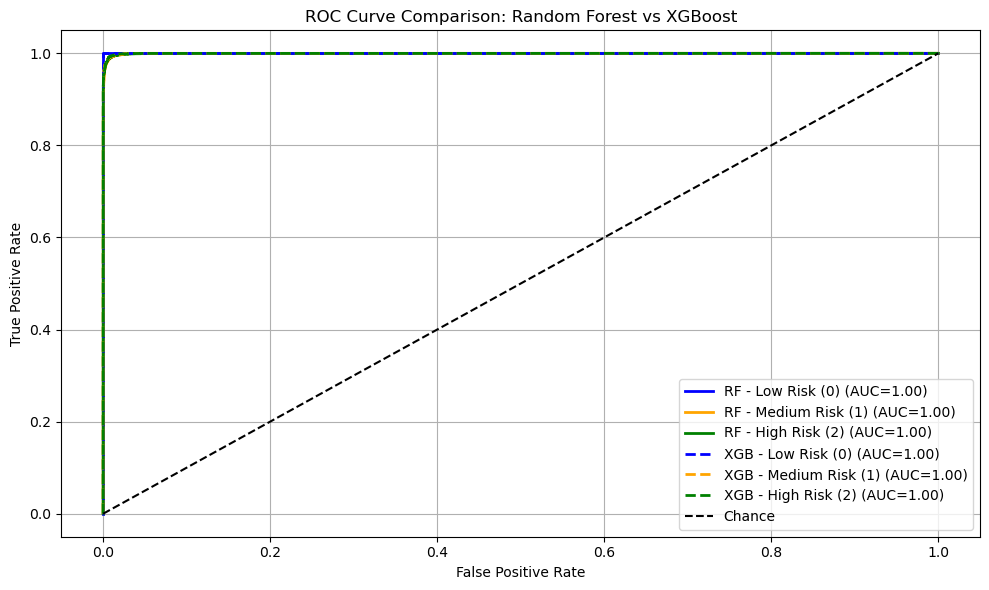

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Load the dataset
file_path = "/Users/anandhu/Downloads/Final Project/combined_dataset/structured/balanced_flood_data.csv"  
df = pd.read_csv(file_path)


# Categorize Flood Risk into Low (0), Medium (1), High (2)
def categorize_flood_risk(percentage):
    if percentage <= 30:
        return 0  # Low Risk
    elif 30 < percentage <= 60:
        return 1  # Medium Risk
    else:
        return 2  # High Risk

df["FloodRiskCategory"] = df["FloodProbability_Percentage"].apply(categorize_flood_risk)

# Separate features (X) and target variable (y)
X = df.drop(columns=["FloodProbability_Percentage", "FloodRiskCategory"])
y = df["FloodRiskCategory"]  # Multi-class classification

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Hyperparameter Tuning for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=3, n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train, y_train)

# Best Random Forest Model
best_rf_model = rf_grid_search.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Hyperparameter Tuning for XGBoost
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_grid_search = GridSearchCV(
    XGBClassifier(eval_metric='mlogloss', random_state=42),
    xgb_param_grid, cv=3, n_jobs=-1, verbose=2
)
xgb_grid_search.fit(X_train, y_train)

# Best XGBoost Model
best_xgb_model = xgb_grid_search.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

# Save the trained models
joblib.dump(best_rf_model, "/Users/anandhu/Downloads/Final Project/combined_dataset/structured/random_forest_model.pkl")
joblib.dump(best_xgb_model, "/Users/anandhu/Downloads/Final Project/combined_dataset/structured/xgboost_model.pkl")
print("Models saved successfully!")

# Display Results
print("Best Random Forest Parameters:", rf_grid_search.best_params_)
print("Random Forest Accuracy:", accuracy_rf)
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

print("Best XGBoost Parameters:", xgb_grid_search.best_params_)
print("XGBoost Accuracy:", accuracy_xgb)
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

# Define cases for high, medium, and low probability based on predictions
def classify_flood_risk(prediction):
    if prediction == 0:
        return "Low Risk"
    elif prediction == 1:
        return "Medium Risk"
    else:
        return "High Risk"

# Apply classification to predictions
rf_risk_levels = [classify_flood_risk(pred) for pred in y_pred_rf]
xgb_risk_levels = [classify_flood_risk(pred) for pred in y_pred_xgb]

print("\nRandom Forest Predicted Risk Levels (First 10):", rf_risk_levels[:10])
print("\nXGBoost Predicted Risk Levels (First 10):", xgb_risk_levels[:10])

# Test cases to validate model
validation_cases = pd.DataFrame({
    "MonsoonIntensity": [9, 2, 6],
    "ClimateChange": [8, 1, 4],
    "Landslides": [9, 2, 5],
    "DamsQuality": [1, 9, 5],
    "CoastalVulnerability": [8, 2, 5],
    "IneffectiveDisasterPreparedness": [9, 1, 4],
    "InadequatePlanning": [9, 1, 5],
    "Deforestation": [8, 2, 5],
    "Urbanization": [9, 2, 5],
    "Encroachments": [8, 1, 4],
    "WetlandLoss": [8, 2, 4],
    "AgriculturalPractices": [8, 2, 4],
    "DeterioratingInfrastructure": [9, 2, 5],
    "PoliticalFactors": [3, 7, 5],
    "Watersheds": [8, 1, 4]
})

# Additional medium-risk test cases
medium_risk_cases = pd.DataFrame({
    "MonsoonIntensity": [5, 6, 4],
    "ClimateChange": [5, 4, 6],
    "Landslides": [4, 5, 6],
    "DamsQuality": [5, 4, 6],
    "CoastalVulnerability": [5, 6, 4],
    "IneffectiveDisasterPreparedness": [4, 5, 6],
    "InadequatePlanning": [5, 4, 6],
    "Deforestation": [4, 6, 5],
    "Urbanization": [5, 4, 6],
    "Encroachments": [4, 5, 6],
    "WetlandLoss": [6, 5, 4],
    "AgriculturalPractices": [4, 6, 5],
    "DeterioratingInfrastructure": [5, 6, 4],
    "PoliticalFactors": [5, 4, 6],
    "Watersheds": [6, 5, 4],
})

rf_medium_preds = best_rf_model.predict(medium_risk_cases)
xgb_medium_preds = best_xgb_model.predict(medium_risk_cases)

rf_medium_risk_levels = [classify_flood_risk(pred) for pred in rf_medium_preds]
xgb_medium_risk_levels = [classify_flood_risk(pred) for pred in xgb_medium_preds]

print("\nRandom Forest Medium Risk Predictions:", rf_medium_risk_levels)
print("XGBoost Medium Risk Predictions:", xgb_medium_risk_levels)




📊 Model Evaluation Metrics:

           Model  Accuracy  Log Loss  AUC (OvR)
0  Random Forest    0.9910    0.0771     0.9998
1        XGBoost    0.9921    0.0213     0.9998


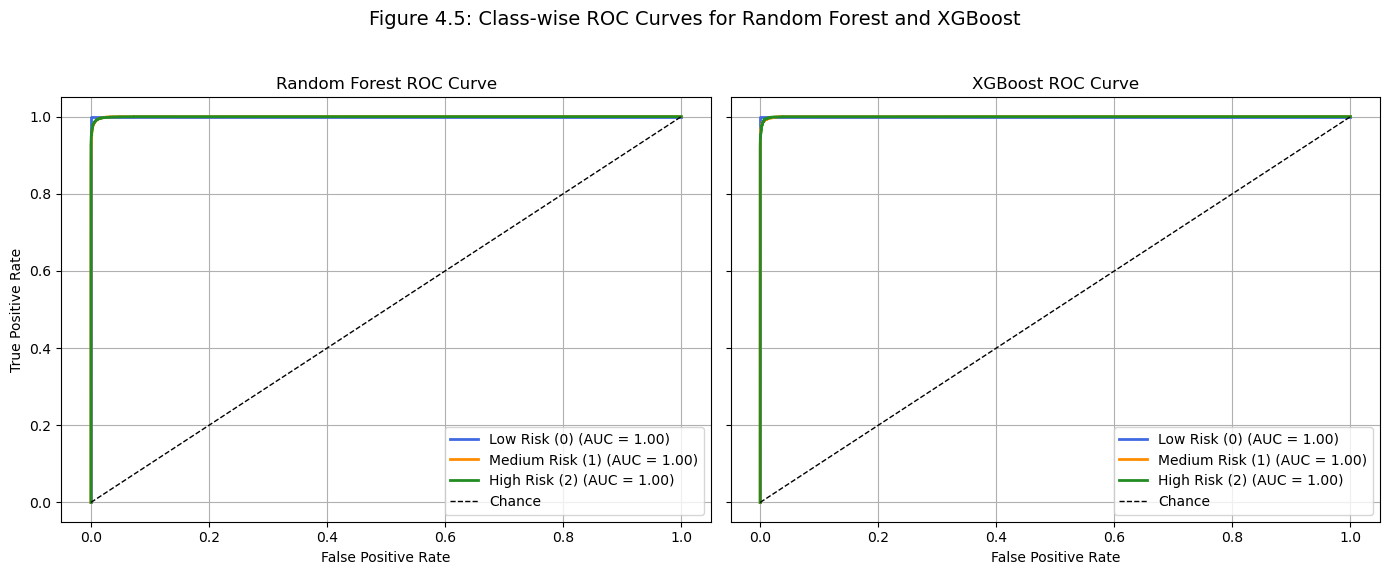

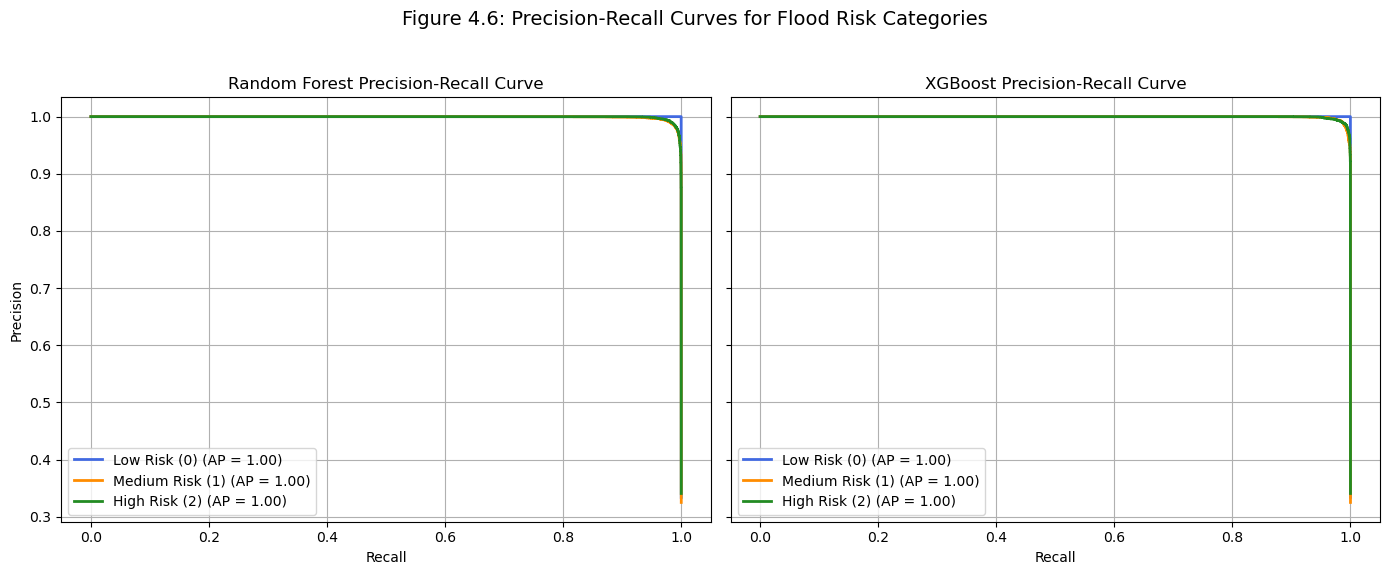

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, roc_auc_score,
    accuracy_score, log_loss,
    precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import label_binarize
import pandas as pd

# ✅ 1. Binarize the test labels (for multiclass ROC & PR)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# ✅ 2. Get predicted probabilities
rf_probs = best_rf_model.predict_proba(X_test)
xgb_probs = best_xgb_model.predict_proba(X_test)

# ✅ 3. Classification Metrics Summary Table
metrics_df = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ],
    "Log Loss": [
        log_loss(y_test, rf_probs),
        log_loss(y_test, xgb_probs)
    ],
    "AUC (OvR)": [
        roc_auc_score(y_test_bin, rf_probs, multi_class='ovr'),
        roc_auc_score(y_test_bin, xgb_probs, multi_class='ovr')
    ]
})

print("\n📊 Model Evaluation Metrics:\n")
print(metrics_df.round(4))

# =====================================================
# 📈 4. ROC Curve Side-by-Side: Random Forest vs XGBoost
# =====================================================
fpr_rf, tpr_rf, roc_auc_rf = {}, {}, {}
fpr_xgb, tpr_xgb, roc_auc_xgb = {}, {}, {}

classes = ['Low Risk (0)', 'Medium Risk (1)', 'High Risk (2)']
colors = ['royalblue', 'darkorange', 'forestgreen']

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# 🔹 Random Forest ROC
for i in range(3):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_test_bin[:, i], rf_probs[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])
    axs[0].plot(fpr_rf[i], tpr_rf[i], color=colors[i], lw=2,
                label=f'{classes[i]} (AUC = {roc_auc_rf[i]:.2f})')

axs[0].plot([0, 1], [0, 1], 'k--', lw=1, label='Chance')
axs[0].set_title("Random Forest ROC Curve")
axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")
axs[0].legend(loc='lower right')
axs[0].grid(True)

# 🔸 XGBoost ROC
for i in range(3):
    fpr_xgb[i], tpr_xgb[i], _ = roc_curve(y_test_bin[:, i], xgb_probs[:, i])
    roc_auc_xgb[i] = auc(fpr_xgb[i], tpr_xgb[i])
    axs[1].plot(fpr_xgb[i], tpr_xgb[i], color=colors[i], lw=2,
                label=f'{classes[i]} (AUC = {roc_auc_xgb[i]:.2f})')

axs[1].plot([0, 1], [0, 1], 'k--', lw=1, label='Chance')
axs[1].set_title("XGBoost ROC Curve")
axs[1].set_xlabel("False Positive Rate")
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.suptitle("Figure 4.5: Class-wise ROC Curves for Random Forest and XGBoost", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# =====================================================
# 📉 5. Precision-Recall Curve: Better for Imbalanced Classes
# =====================================================
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# 🔹 Random Forest PR
for i in range(3):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], rf_probs[:, i])
    pr_auc = average_precision_score(y_test_bin[:, i], rf_probs[:, i])
    axs[0].plot(recall, precision, color=colors[i], lw=2,
                label=f'{classes[i]} (AP = {pr_auc:.2f})')

axs[0].set_title("Random Forest Precision-Recall Curve")
axs[0].set_xlabel("Recall")
axs[0].set_ylabel("Precision")
axs[0].legend(loc='lower left')
axs[0].grid(True)

# 🔸 XGBoost PR
for i in range(3):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], xgb_probs[:, i])
    pr_auc = average_precision_score(y_test_bin[:, i], xgb_probs[:, i])
    axs[1].plot(recall, precision, color=colors[i], lw=2,
                label=f'{classes[i]} (AP = {pr_auc:.2f})')

axs[1].set_title("XGBoost Precision-Recall Curve")
axs[1].set_xlabel("Recall")
axs[1].legend(loc='lower left')
axs[1].grid(True)

plt.suptitle("Figure 4.6: Precision-Recall Curves for Flood Risk Categories", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()